# Classifier Model

This is a basic 2-layer neural network implemented with sklearn for use with HAR spectral and cepstral data

## Notes

It pretty much doesn't work. That's pretty disappointing. It may be because the cepstral data is better suited to a different classification method, but I suspect it might have more to do with poorly sampled data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import os
import sys
import multiprocessing as mp
from multiprocessing import Manager, Pool, Lock
from glob import glob
from time import time
# set multiprocessing start method to 'fork' for macOS
# you can only run this once
mp.set_start_method('fork')

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

%matplotlib inline


In [2]:
# GLOBALS

DATA_DIR_PATH = "../data/"


In [3]:
# read data from files for phone accel

filepaths = glob("../data/*_phone_accel.txt")

def read_file_csv(filepath):
    # read data from csv files
    df = pd.read_csv(filepath, engine='c')

    return df

# using multiprocessing again to speed up reads
with Pool(processes=2) as pool:
    dataframes = pool.map(read_file_csv, filepaths)
    
pa_df = pd.concat(dataframes,
                  # columns=dataframes[0].columns,
                  ignore_index=True,
                  copy=False)

# treat sid as object
pa_df['sid'] = pa_df['sid'].astype('object')

# Label Encoding
# encoder = LabelEncoder()
# encoder.fit(pa_df['label'])

# feat_names=list(encoder.classes_)
# label_df = pd.DataFrame(encoder.transform(pa_df['label'].to_numpy().reshape(-1, 1)),
#                         columns=['label']).astype('int')

# pa_df_enc = pd.concat([pa_df.drop(['label'], axis=1), label_df], axis=1)

# OneHotEncoding for the label (for learning, keep data separate)
pa_df_enc = pd.get_dummies(pa_df, columns=['label'])
feat_names = [f'label_{l}' for l in pa_df['label'].unique()]

# failed attempt to use sklearn version
# encoder = OneHotEncoder(handle_unknown='ignore')
# encoder.fit(pa_df['label'].unique().reshape(-1, 1))

# feat_names = encoder.get_feature_names()
# ohe = encoder.transform(pa_df['label'].to_numpy().reshape(-1, 1)).toarray()
# label_df = pd.DataFrame(ohe, columns=feat_names).astype('int')

# pa_df_enc = pd.concat([pa_df.drop(['label'], axis=1), label_df], axis=1)

pa_df.info()
pa_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Columns: 143 entries, sid to label
dtypes: float64(141), object(2)
memory usage: 949.7+ KB


,sid,xmag0.5,xmag1.0,xmag1.5,xmag2.0,xmag2.5,xmag3.0,xmag3.5,xmag4.0,xmag4.5,...,zcc7,zcc8,zcc9,zcc10,zcc11,zcc12,zcc13,zcc14,zcc15,label
0,1650,12.287781,14.232294,87.418132,45.544975,49.851958,39.942064,77.532593,54.060249,62.440067,...,-3.927471,-6.249044,3.481218,3.168042,2.302825,1.537452,6.436535,8.725973,13.593631,A
1,1650,4.076830,9.923520,13.291454,23.362957,113.900756,40.729466,67.563437,291.678553,70.345475,...,4.060621,10.326195,-7.946185,-8.988227,-36.470117,-8.987360,12.425264,0.515152,3.450111,B
2,1650,13.250744,39.422665,104.235644,82.779274,116.940606,126.920503,81.259269,81.131139,95.391377,...,-3.482785,-0.751014,-1.838345,-3.094744,1.364215,1.660025,2.644441,1.811932,0.396936,C
3,1650,0.596909,0.680031,1.215236,1.539782,1.779171,1.665725,2.266116,2.494541,2.175828,...,0.353853,0.485429,-0.119926,-0.345074,0.628659,-0.595613,0.067600,1.174231,1.286160,D
4,1650,0.620815,0.963923,0.954349,1.637456,1.812120,2.332727,2.998322,3.042084,2.604576,...,2.041495,-1.403664,-2.817036,-1.800172,-0.387745,0.298356,-1.114774,-2.405370,-2.196643,E


In [4]:
pa_df_enc.info()
pa_df_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Columns: 160 entries, sid to label_S
dtypes: float64(141), object(1), uint8(18)
memory usage: 958.0+ KB


,sid,xmag0.5,xmag1.0,xmag1.5,xmag2.0,xmag2.5,xmag3.0,xmag3.5,xmag4.0,xmag4.5,...,label_I,label_J,label_K,label_L,label_M,label_O,label_P,label_Q,label_R,label_S
0,1650,12.287781,14.232294,87.418132,45.544975,49.851958,39.942064,77.532593,54.060249,62.440067,...,0,0,0,0,0,0,0,0,0,0
1,1650,4.076830,9.923520,13.291454,23.362957,113.900756,40.729466,67.563437,291.678553,70.345475,...,0,0,0,0,0,0,0,0,0,0
2,1650,13.250744,39.422665,104.235644,82.779274,116.940606,126.920503,81.259269,81.131139,95.391377,...,0,0,0,0,0,0,0,0,0,0
3,1650,0.596909,0.680031,1.215236,1.539782,1.779171,1.665725,2.266116,2.494541,2.175828,...,0,0,0,0,0,0,0,0,0,0
4,1650,0.620815,0.963923,0.954349,1.637456,1.812120,2.332727,2.998322,3.042084,2.604576,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# outliers analysis

ocsvm = OneClassSVM(nu=0.01)
pred_ocsvm = ocsvm.fit_predict(pa_df.select_dtypes(np.number))
ocsvm_ct = pd.crosstab(pred_ocsvm, columns=['count'])
print("OCSVM Results:", ocsvm_ct)

isof = IsolationForest(n_jobs=2)
pred_isof = isof.fit_predict(pa_df.select_dtypes(np.number))
isof_ct = pd.crosstab(pred_isof, columns=['count'])
print("ISOF Results:", isof_ct)

outliers = np.intersect1d(np.where(pred_isof == -1), np.where(pred_ocsvm == -1))

print("Num Outliers:", len(outliers))
print("OCSVM && ISOF:", list(outliers))

# we will not be dropping the outliers for now

OCSVM Results: col_0  count
row_0       
-1        29
 1       821
ISOF Results: col_0  count
row_0       
-1        83
 1       767
Num Outliers: 22
OCSVM && ISOF: [1, 55, 70, 155, 173, 191, 260, 277, 292, 327, 378, 481, 498, 546, 651, 669, 701, 715, 716, 748, 779, 833]


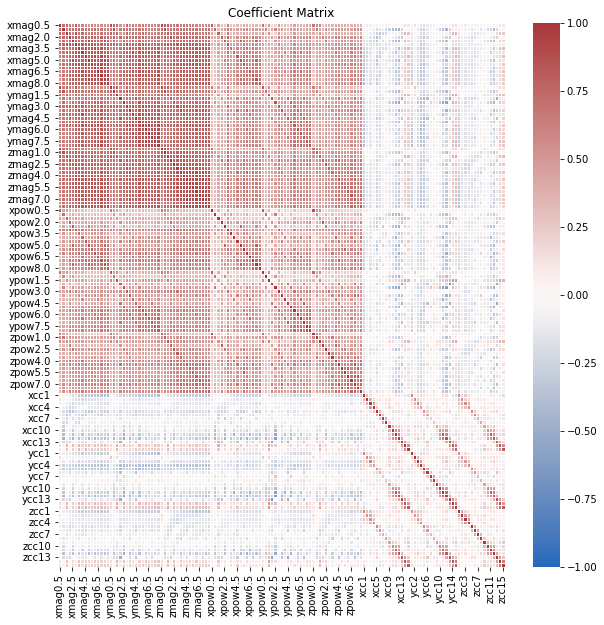

In [6]:
# visualize correlation matrix (gonna be ugly)
corr_mat = pa_df.drop(['sid', 'label'], axis=1).corr()

# figure plotting
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_mat, annot=False, linewidth=0.5, ax=ax, vmin=-1, vmax=1, cmap='vlag')
ax.set_title("Coefficient Matrix")
plt.show()

In [7]:
# scaling
to_scale = list(pa_df_enc.select_dtypes(np.number).columns)
to_scale = list(set(to_scale).difference(set(feat_names)))

# print(to_scale)
scalers = {k:StandardScaler() for k in to_scale}

for col in to_scale:
    pa_df_enc.loc[:,col] = scalers[col].fit_transform(np.array(pa_df_enc.loc[:,col]).reshape(-1, 1))
pa_df_enc.head()

,sid,xmag0.5,xmag1.0,xmag1.5,xmag2.0,xmag2.5,xmag3.0,xmag3.5,xmag4.0,xmag4.5,...,label_I,label_J,label_K,label_L,label_M,label_O,label_P,label_Q,label_R,label_S
0,1650,0.967953,0.327880,3.457810,0.919361,0.523815,0.663863,1.173195,0.732385,0.777000,...,0,0,0,0,0,0,0,0,0,0
1,1650,-0.130510,0.057251,-0.028119,0.198859,1.829006,0.690832,0.943718,6.750059,0.952356,...,0,0,0,0,0,0,0,0,0,0
2,1650,1.096778,1.910059,4.248682,2.128781,1.890953,3.642915,1.258978,1.417954,1.507916,...,0,0,0,0,0,0,0,0,0,0
3,1650,-0.596055,-0.523322,-0.596024,-0.509987,-0.455816,-0.647119,-0.559341,-0.573515,-0.559762,...,0,0,0,0,0,0,0,0,0,0
4,1650,-0.592857,-0.505491,-0.608292,-0.506815,-0.455145,-0.624274,-0.542486,-0.559649,-0.550252,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# try learning with just the cepstral coefficients first
drop = ['xmag0.5', 'xmag1.0', 'xmag1.5', 'xmag2.0', 'xmag2.5', 'xmag3.0', 'xmag3.5', 'xmag4.0', 
        'xmag4.5', 'xmag5.0', 'xmag5.5', 'xmag6.0', 'xmag6.5', 'xmag7.0', 'xmag7.5', 'xmag8.0', 
        'ymag0.5', 'ymag1.0', 'ymag1.5', 'ymag2.0', 'ymag2.5', 'ymag3.0', 'ymag3.5', 'ymag4.0', 
        'ymag4.5', 'ymag5.0', 'ymag5.5', 'ymag6.0', 'ymag6.5', 'ymag7.0', 'ymag7.5', 'ymag8.0', 
        'zmag0.5', 'zmag1.0', 'zmag1.5', 'zmag2.0', 'zmag2.5', 'zmag3.0', 'zmag3.5', 'zmag4.0', 
        'zmag4.5', 'zmag5.0', 'zmag5.5', 'zmag6.0', 'zmag6.5', 'zmag7.0', 'zmag7.5', 'zmag8.0',
        'xpow0.5', 'xpow1.0', 'xpow1.5', 'xpow2.0', 'xpow2.5', 'xpow3.0', 'xpow3.5', 'xpow4.0', 
        'xpow4.5', 'xpow5.0', 'xpow5.5', 'xpow6.0', 'xpow6.5', 'xpow7.0', 'xpow7.5', 'xpow8.0', 
        'ypow0.5', 'ypow1.0', 'ypow1.5', 'ypow2.0', 'ypow2.5', 'ypow3.0', 'ypow3.5', 'ypow4.0', 
        'ypow4.5', 'ypow5.0', 'ypow5.5', 'ypow6.0', 'ypow6.5', 'ypow7.0', 'ypow7.5', 'ypow8.0', 
        'zpow0.5', 'zpow1.0', 'zpow1.5', 'zpow2.0', 'zpow2.5', 'zpow3.0', 'zpow3.5', 'zpow4.0', 
        'zpow4.5', 'zpow5.0', 'zpow5.5', 'zpow6.0', 'zpow6.5', 'zpow7.0', 'zpow7.5', 'zpow8.0',
        'xcc10', 'xcc11', 'xcc12', 'xcc13', 'xcc14', 'xcc15', 
        'ycc10', 'ycc11', 'ycc12', 'ycc13', 'ycc14', 'ycc15', 
        'zcc10', 'zcc11', 'zcc12', 'zcc13', 'zcc14', 'zcc15']

# 70:30 split
train, test = train_test_split(pa_df_enc.drop(['sid'] + drop, axis=1), test_size=0.3)
train = train.copy()
test = test.copy()

# skip scaling

In [10]:
# begin learning

# shuffle the training set
train = train.sample(frac=1)

# split into independent and dependent variables
y_train, x_train = train[feat_names].copy(), train.drop(feat_names, axis=1)
y_test, x_test = test[feat_names].copy(), test.drop(feat_names, axis=1)

# construct neural network
nn = MLPClassifier(hidden_layer_sizes=(40, 40),
                   activation='logistic',
                   solver='adam',
                   max_iter=1000000,
#                    early_stopping=True,
                   random_state=1
                )

# measuring training time
t = time()
print("Begin Training...")

# train model
nn.fit(x_train, y_train)

# final accuracy scores
train_score = nn.score(x_train, y_train)
test_score = nn.score(x_test, y_test)

# final recall scores
train_recall = recall_score(y_train, nn.predict(x_train),
                            zero_division=0,
                            average='macro')
test_recall = recall_score(y_test, nn.predict(x_test),
                            zero_division=0,
                            average='macro')

# final precision score
train_precision = precision_score(y_train, nn.predict(x_train),
                            zero_division=0,
                            average='macro')
test_precision = precision_score(y_test, nn.predict(x_test),
                            zero_division=0,
                            average='macro')


print(f"Elapsed Time: {time()-t} s")
print(f"Final Weights: {[w[0] for w in nn.coefs_[-1]]}\n")
print(f"Final Training Accuracy {round(train_score, 5)}")
print(f"Final Testing Accuracy {round(test_score, 5)}")
print(f"Final Training Recall {round(train_recall, 5)}")
print(f"Final Testing Recall {round(test_recall, 5)}")
print(f"Final Training Precision {round(train_precision, 5)}")
print(f"Final Testing Precision {round(test_precision, 5)}")

Begin Training...
Elapsed Time: 45.21302819252014 s
Final Weights: [1.5501284118841927, 0.6967817208012286, -0.060687060559514144, 0.22539980047934105, -1.2099369026853009, -1.5638012350062185, 1.2616911501863075, -0.5563663034233912, -2.1669976166179947, 0.3724134421161326, -2.897499096698311, -5.092289971948764, -0.8724586900172364, 3.2965827762750317, -0.06624528598856205, -4.29586438128446, 1.4580041769303396, -1.502868543833326, 1.2737710230319095, 2.712561142498498, -4.125850091243696, 2.8797397798718083, -0.22909722367699797, -1.6817897780706228, 2.479680893751805, 0.24361836568426523, -0.8157731258974373, 2.0908662948561445, 0.5422290493466732, 2.0561747702532656, -0.18107457010162945, -0.20303053581503852, -4.145813622652152, 0.25015289064773366, -2.6119212143876127, -4.654062114843605, 1.4285034869490636, 0.5256895683431464, -3.5199608551929393, -0.061754141766532045]

Final Training Accuracy 1.0
Final Testing Accuracy 0.12549
Final Training Recall 1.0
Final Testing Recall 0.

# References

## Official Docs

- [sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)
- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

## Helpful Links

- [OneHotEncoder with DataFrame](https://stackoverflow.com/questions/58101126/)
- [some guy from spain's degree project](https://core.ac.uk/download/pdf/148681945.pdf)
- [research paper with good results](https://www.researchgate.net/publication/318124946_Assessment_of_Homomorphic_Analysis_for_Human_Activity_Recognition_From_Acceleration_Signals)
- [lpcc](https://link.springer.com/content/pdf/bbm%3A978-3-319-17163-0%2F1.pdf)
- [spectral analysis of signals](http://user.it.uu.se/~ps/SAS-new.pdf)
- [power spectrum (wiki)](https://en.wikipedia.org/wiki/Spectral_density)